In [15]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
import numpy as np
import pandas as pd
import os
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
from PIL import Image
import albumentations as A
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
from fixpoint_utils import (
    keypoints_IoU_mult,
    get_acc, 
    save_checkpoint, 
    load_checkpoint, 
    get_loader_keypoint)

from torch.optim.lr_scheduler import StepLR
from models_2 import ResNet, BasicBlock, KeypointModel, KeypointCNN, EfficentNet

In [16]:
# HYPERPARAMETERS:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LOGGING = False
NUM_EPOCHS = 50
random.seed(42)
torch.manual_seed(42)

In [17]:
train_loader, test_loader = get_loader_keypoint()

In [18]:
model = EfficentNet().to(DEVICE)

In [24]:
checkpoint = r'/home/alex/Documents/new try/Data/Studie_daten/safe_states/EfficentNet_4_0.001_1_1_3.pth.tar'
load_checkpoint(model, checkpoint)

=> Loading checkpoint


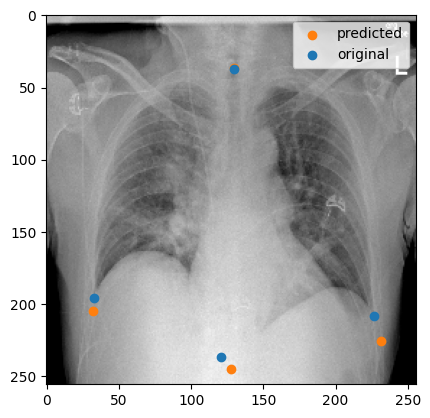

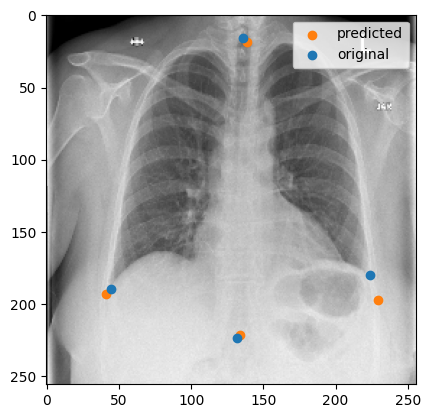

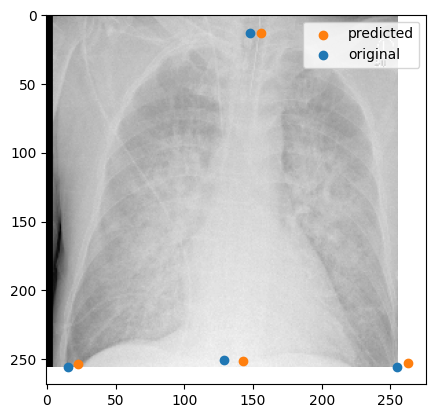

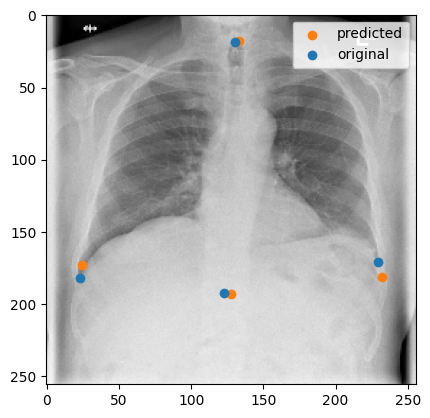

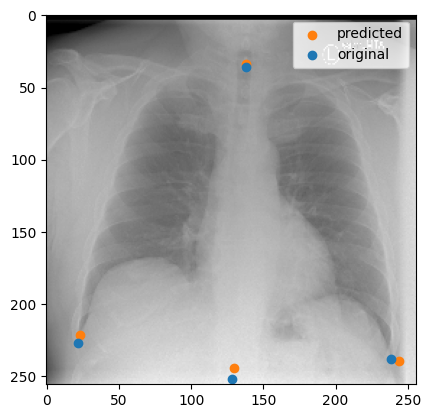

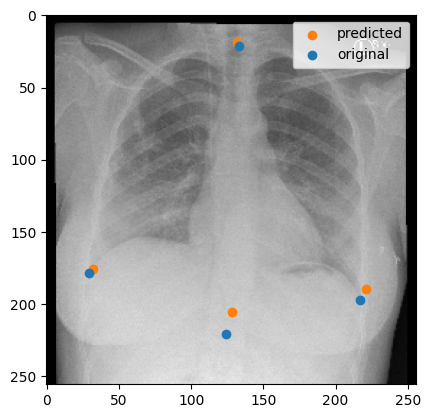

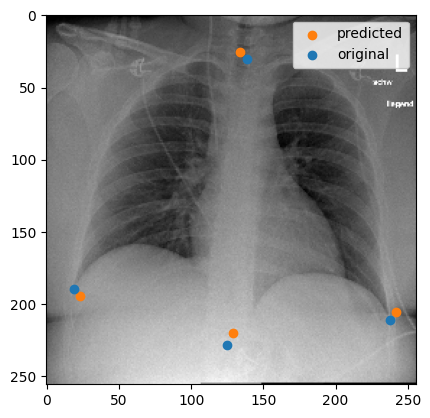

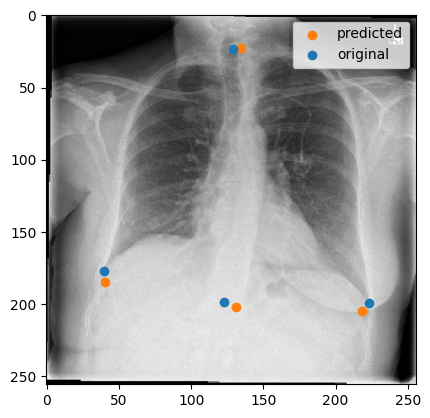

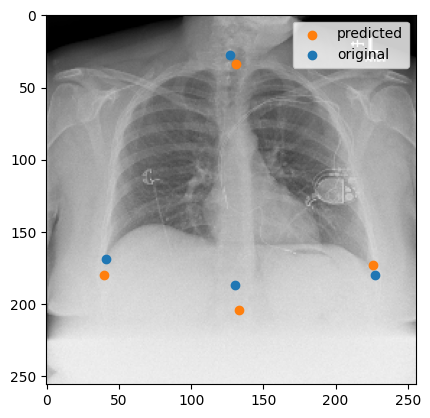

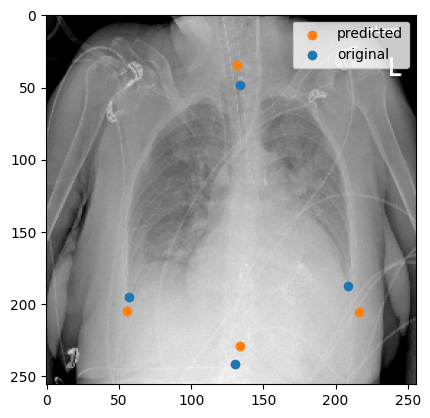

MSE: 67.9080322265625
Box IoU: 0.8865251933058648


In [25]:
loss_func = nn.MSELoss()

model.eval()
loss = 0
IoU = 0
for image, targ in test_loader:
        img = image.to(device = DEVICE).repeat(1, 3, 1, 1)
        target = targ.to(DEVICE)
        pred = model(img)
        loss += loss_func(pred, target.squeeze(1))
        IoU += keypoints_IoU_mult(image, targ.squeeze(1), pred)
        pred = pred[0].to('cpu').detach().numpy()
        plt.imshow(image[0][0], cmap='gray')
        for i in range(0, 8, 2):
                scatter1 = plt.scatter(pred[i], pred[i+1],color = 'C1')
                scatter2 = plt.scatter(targ[0,0,i], targ[0,0,i+1], color = 'C0')
        scatter1.set_label('predicted')
        scatter2.set_label('original')
        plt.legend()
        plt.show()
print('MSE:', loss.item()/len(test_loader))
print('Box IoU:', IoU.item()/len(test_loader.dataset))

del loss, pred, IoU, target, img
torch.cuda.empty_cache()  

[67.83016204833984, 26.839763641357422, 59.02512741088867, 34.04965591430664, 75.2691879272461, 116.62138366699219, 14.463018417358398, 45.30695343017578, 67.07870483398438, 95.10313415527344, 40.664222717285156, 7.232450485229492, 91.76466369628906, 89.42057800292969, 69.75750732421875, 115.38156127929688, 47.00601577758789, 38.2945556640625, 45.43024826049805, 36.961387634277344, 105.20204162597656, 42.60468292236328, 130.53689575195312, 32.308319091796875, 26.440940856933594, 20.26673698425293, 115.78953552246094, 48.32771682739258, 20.822660446166992, 147.3277587890625, 8.597428321838379, 114.4764175415039, 48.761085510253906, 119.58169555664062, 62.89067840576172, 24.771377563476562, 216.48818969726562, 64.71772766113281, 26.200786590576172, 73.49453735351562, 49.19176483154297, 118.30267333984375, 96.2633056640625, 71.29144287109375, 14.109740257263184, 22.696155548095703, 39.43539047241211, 11.508203506469727, 28.841854095458984, 21.725332260131836, 62.917091369628906, 18.091495

(array([ 5.,  5.,  7.,  7., 12.,  5.,  7., 15.,  9.,  8.,  1.,  5.,  9.,
         5.,  7.,  2.,  2.,  4.,  2.,  3.,  4.,  0.,  6.,  2.,  1.,  1.,
         2.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  2.,  0.,  1.,  0.,  0.,
         0.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  1.]),
 array([  3.62600803,   8.55871065,  13.49141327,  18.42411589,
         23.3568185 ,  28.28952112,  33.22222374,  38.15492636,
         43.08762897,  48.02033159,  52.95303421,  57.88573683,
         62.81843945,  67.75114206,  72.68384468,  77.6165473 ,
         82.54924992,  87.48195253,  92.41465515,  97.34735777,
        102.28006039, 107.212763  , 112.14546562, 117.07816824,
        122.01087086, 126.94357347, 131.87627609, 136.80897871,
        141.74168133, 146.67438395, 151.60708656, 156.53978918,
        161.4724918 , 166.40519442, 171.33789703, 176.27059965,
        181.20330227, 186.13600489, 191.0687075 , 196.00141012,
        200.93411274, 205.86681536, 210.79951797, 215.73222059,
        220.

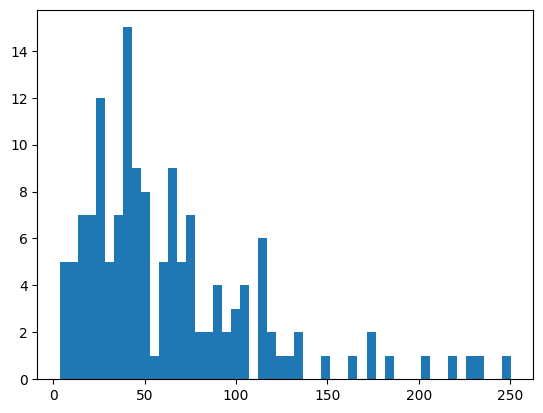

In [26]:
model.eval()
loss = []
for image, targ in test_loader:
        for i in range(image.shape[0]):
            img = image[i].to(device = DEVICE).unsqueeze(0).repeat(1, 3, 1, 1)
            target = targ[i].to(DEVICE)
            pred = model(img)
            loss.append(loss_func(pred, target.unsqueeze(0).squeeze(1)).item())
print(loss)
plt.hist(loss, bins = 50)

Plot highes loss

In [27]:
from fixpoint_utils import get_test_dataset

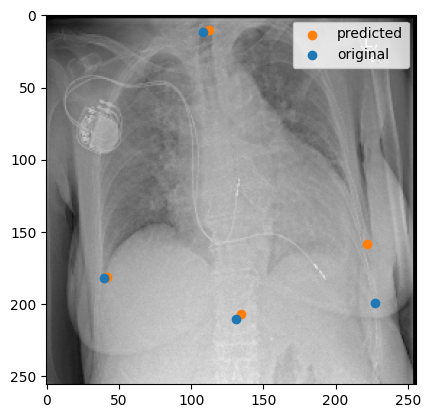

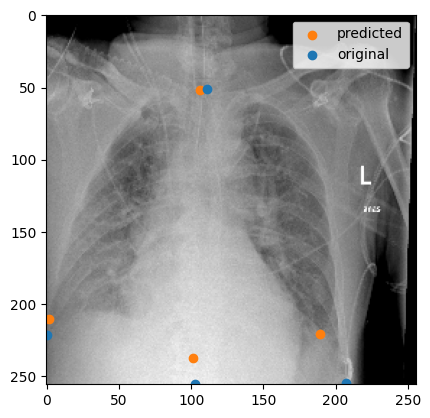

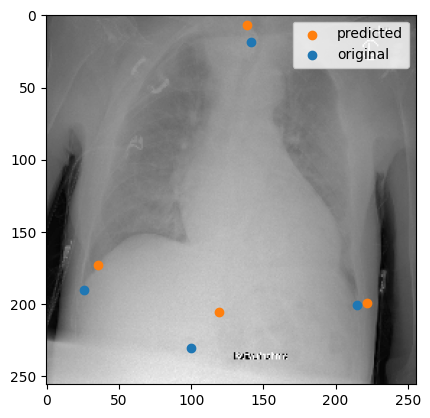

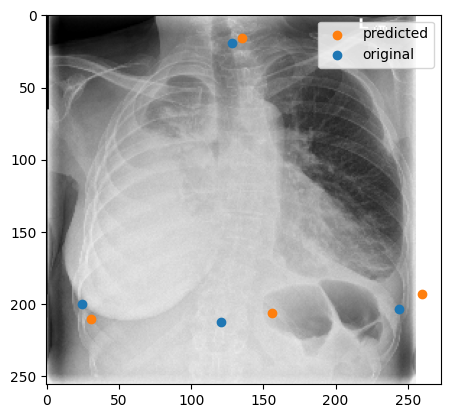

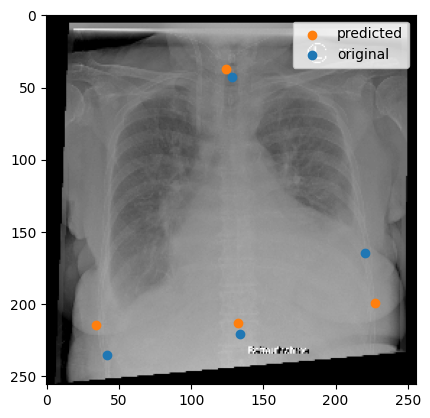

In [29]:
indexes = [i for i, loss in enumerate(loss) if loss > 200]
test_keypoint_ds = get_test_dataset()
subset = Subset(test_keypoint_ds, indexes)

subset_loader = DataLoader(subset,
                          batch_size= 1,
                          num_workers= 0,
                          pin_memory= False,
                          shuffle= False)

for image, kp in subset_loader:
    img = image.to(device = DEVICE).repeat(1, 3, 1, 1)
    target = kp.to(DEVICE)
    pred = model(img)
    pred = pred[0].to('cpu').detach().numpy()
    plt.imshow(image[0][0], cmap='gray')
    for i in range(0, 8, 2):
        scatter1 = plt.scatter(pred[i], pred[i+1],color = 'C1')
        scatter2 = plt.scatter(kp[0,0,i], kp[0,0,i+1], color = 'C0')
    scatter1.set_label('predicted')
    scatter2.set_label('original')
    plt.legend()
    plt.show()